# Contagiousness Delta-Variant (B.1.617.2) of SARS-CoV-2

In [42]:
#import Pkg; Pkg.add("DataFrames"); Pkg.add("Plots");  Pkg.add("GLM");  Pkg.add("StatsBase"); Pkg.add("Gadfly"); Pkg.add("GR");Pkg.add("ColorSchemes"); Pkg.add("LaTeXStrings"); Pkg.add("Latexify"); Pkg.add("Formatting")
using DataFrames, Plots, GLM, StatsBase, LinearAlgebra, Latexify, Formatting,  ColorSchemes, LaTeXStrings

## 🇩🇰 Data: Weekly number of new cases, sequenced tests, and number of Delta-variant cases
Cases is the weekly number of new COVID-19 cases
$n$ is the number of sequenced positive tests (with definite outcome)
$x$ is the number of sequenced positive tests identified as the Delta variant.

In [43]:
# Data up until Week 29. Vintage: August 11, 2021
dfDelta    = DataFrame(
    Week    = [  "W20",  "W21", "W22", "W23", "W24", "W25", "W26", "W27", "W28", "W29"], 
    Tested  = [1167981,1013403,911764,720274,575207,524837,608540,624414,583932, 473843], 
    Cases   = [   6867,   6698,  5662,  2811,  1649,  1315,  2674,  4614,  6818, 5289],
    n       = [   5366,   5213,  4565,  2467,  1364,  1165,  2418,  3322,  6253, 4800],
    x       = [     13,     15,    36,    66,    91,   345,  1555,  2702,  5781, 4591])

,Week,Tested,Cases,n,x
,String,Int64,Int64,Int64,Int64
1,W20,1167981,6867,5366,13
2,W21,1013403,6698,5213,15
3,W22,911764,5662,4565,36
4,W23,720274,2811,2467,66
5,W24,575207,1649,1364,91
6,W25,524837,1315,1165,345
7,W26,608540,2674,2418,1555
8,W27,624414,4614,3322,2702
9,W28,583932,6818,6253,5781


## Compute Sequencing ratio, Delta Prevalence, and standard errors
For a binomial distribution, the expected value is estimated by $$q = x/n$$ and the corresponding standard errors are $$\sigma = \sqrt{q(1-q)/n}.$$

In [44]:
# Proportion of positive tests being sequenced
dfDelta.SeqRatio = dfDelta.n ./ dfDelta.Cases
# Proportion of sequenced tests that are Delta variant
q = dfDelta.x ./ dfDelta.n
dfDelta.q = q
# standard errors for q = x/n
dfDelta.σ = sqrt.(dfDelta.q.*(1 .-dfDelta.q) ./ dfDelta.n) 
dfDelta

,Week,Tested,Cases,n,x,SeqRatio,q,σ
,String,Int64,Int64,Int64,Int64,Float64,Float64,Float64
1,W20,1167981,6867,5366,13,0.781418,0.00242266,0.000671111
2,W21,1013403,6698,5213,15,0.778292,0.00287742,0.000741877
3,W22,911764,5662,4565,36,0.806252,0.00788609,0.00130916
4,W23,720274,2811,2467,66,0.877624,0.0267531,0.00324874
5,W24,575207,1649,1364,91,0.827168,0.0667155,0.00675637
6,W25,524837,1315,1165,345,0.885932,0.296137,0.013376
7,W26,608540,2674,2418,1555,0.904263,0.643093,0.00974285
8,W27,624414,4614,3322,2702,0.719983,0.813365,0.00675988
9,W28,583932,6818,6253,5781,0.917131,0.924516,0.00334072


## The Prevalence of Delta Variant by week

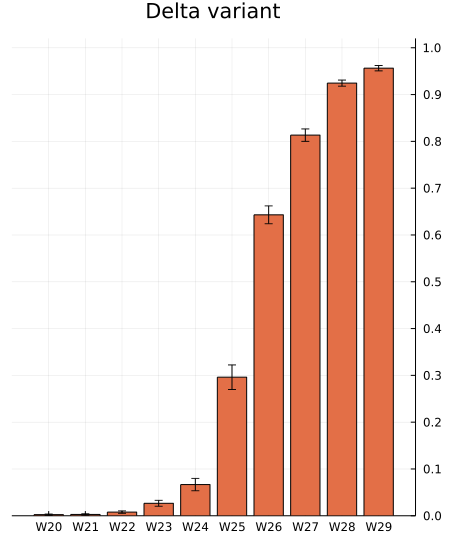

In [45]:
T = size(dfDelta,1)
bar( dfDelta.q, legend=false, xticks = (1:T, dfDelta.Week),
    ylims=(0,1.02), yticks = 0.0:0.1:1.0, ymirror = true,
    title="Delta variant", seriescolor=2, size=(450,550),
    yerror=1.96.*dfDelta.σ,fmt=png
)

# Basic Model for Analysis
Virus A (old variant).  New weekly cases evolve according to $A_t = a_t A_{t-1}$

Virus B (Delta variant). New weekly cases evolve according to $B_t = b_t B_{t-1}$ 

The model will be based on the assumption that $$b_t = \gamma a_t,$$ where $\gamma$ measure the relative contagiouness of Delta relative to the existing variant. 

$\gamma$ is the parameter of interest.

# Empirical Measurements on $\gamma$
Note that 
$$ \frac{B_t/B_{t-1}}{A_t/A_{t-1}} = \frac{\gamma a_t}{a_t}=\gamma. $$
We can rearrange the terms in the expression as follows,
$$ \gamma = \left. \frac{B_t}{A_t} \right/ \frac{B_{t-1}}{A_{t-1}}. $$ 
We do not observe the ratios, $\frac{B_t}{A_t}$ and $\frac{B_{t-1}}{A_{t-1}}$, but we can use the observed proportion of B117 and scale the case numbers up. 

In [46]:
dfDelta.Â = dfDelta.Cases .* (1.0 .-dfDelta.q)
dfDelta.B̂ = dfDelta.Cases .* dfDelta.q
hcat(dfDelta.Week,convert(Array{Int64},hcat(round.(dfDelta.Â),round.(dfDelta.B̂))))

10×3 Matrix{Any}:
 "W20"  6850    17
 "W21"  6679    19
 "W22"  5617    45
 "W23"  2736    75
 "W24"  1539   110
 "W25"   926   389
 "W26"   954  1720
 "W27"   861  3753
 "W28"   515  6303
 "W29"   230  5059

This gives os a crude approximation to $\gamma$,
$$ \hat\gamma_t = \frac{\hat B_t/\hat B_{t-1}}{\hat A_t/\hat A_{t-1}}, $$ 
which we compute and plot below.

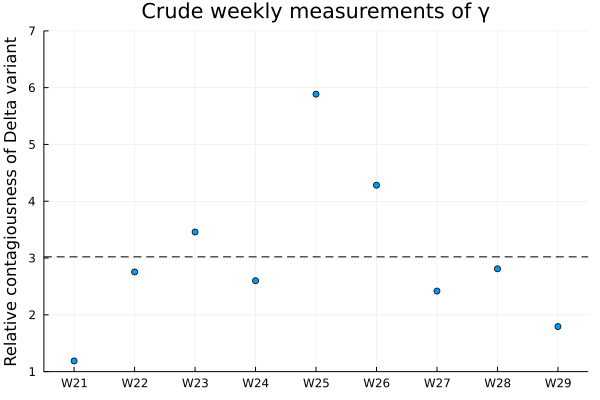

In [47]:
dfDelta.odds = dfDelta.q ./ (1.0 .- dfDelta.q)
scatter(dfDelta.Week[2:end], dfDelta.odds[2:end]./dfDelta.odds[1:end-1],legend=:none, ylim=(1,7),
    title="Crude weekly measurements of γ",ylabel ="Relative contagiousness of Delta variant",fmt=png)
plot!(x -> sum(dfDelta.odds[2:end]./dfDelta.odds[1:end-1])/(T-1),xlim=(0,T-1),linestyle = :dash, linecolor = :black)

It would be nice to add some standard errors... so let's do that... we can use...
$$ \hat\gamma_t = \frac{\hat B_t/\hat B_{t-1}}{\hat A_t/\hat A_{t-1}}  = \left.  \frac{x_t}{n_t-x_t} \right/ \frac{x_{t-1}}{n_{t-1}-x_{t-1}}, $$ 
ratio of two binomial... crunch crunch.. delta-method... crunch crunch...

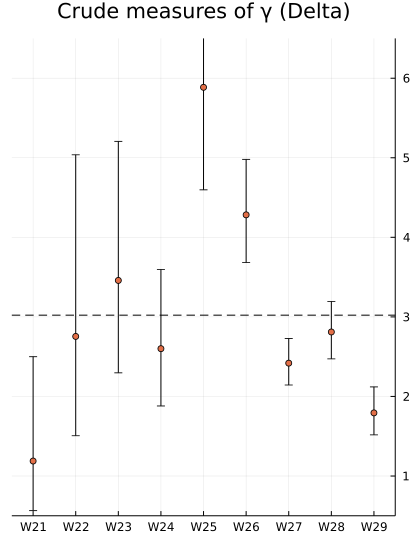

In [48]:
VarLogOdds    = 1.0 ./ ( dfDelta.n .* dfDelta.q .* (1 .- dfDelta.q))
StdErrRelLogOdds = sqrt.(VarLogOdds[2:end] .+ VarLogOdds[1:end-1])
OddsRatio = dfDelta.odds[2:end]./dfDelta.odds[1:end-1]

scatter(dfDelta.Week[2:end], OddsRatio,legend=:none, ylim=(0.5,6.5), fmt=png, 
    seriescolor=2, size=(420,550),ymirror = true,
    yerror=(OddsRatio .- exp.(log.(OddsRatio) .- 1.96.*StdErrRelLogOdds) ,exp.(log.(OddsRatio) .+ 1.96.*StdErrRelLogOdds) .- OddsRatio),
    title="Crude measures of γ (Delta)"#,
    #ylabel = "Relative contagiousness of Delta"
)
plot!(x -> sum(dfDelta.odds[2:end]./dfDelta.odds[1:end-1])/(T-1),xlim=(0,T-1),linestyle = :dash, linecolor = :black)

These are noisy measurements with an average just above 3. The exact figure is: 

In [49]:
print("Crude estimate of γ is ", round(sum(dfDelta.odds[2:end]./dfDelta.odds[1:end-1])/(T-1),digits=2))

Crude estimate of γ is 3.02

Below we use a more precise estimation method, maximum likelhood, and find $\hat\gamma\approx3.16$.

## Align Data with Week numbers

In [50]:
#Add column with time trend for glm estimation
    dfDelta.time_trend = convert(Array{Float64},collect(1:size(dfDelta,1)))
####.+19
#We add 19 to align with week numbers

10-element Vector{Float64}:
  1.0
  2.0
  3.0
  4.0
  5.0
  6.0
  7.0
  8.0
  9.0
 10.0

## The ratio of Delta variant cases to all cases
We can introduce the ratio of Delta cases to all cases,
$$\lambda_t = \frac{B_t}{A_t+B_t}.$$
From the dynamics for $A_t$ and $B_t$ it follows that the Delta-ratio, progresses in the following manner:
$$\lambda_{t+1}= \frac{\gamma\lambda_t}{\gamma\lambda_t+(1-\lambda_t)}.$$
Below we estimate $\gamma\approx 1.8$ which implies that the percentage of Delta variant cases from one week to the next will change as shown in the following figure, that includes the Danish progression of Delta variant cases.

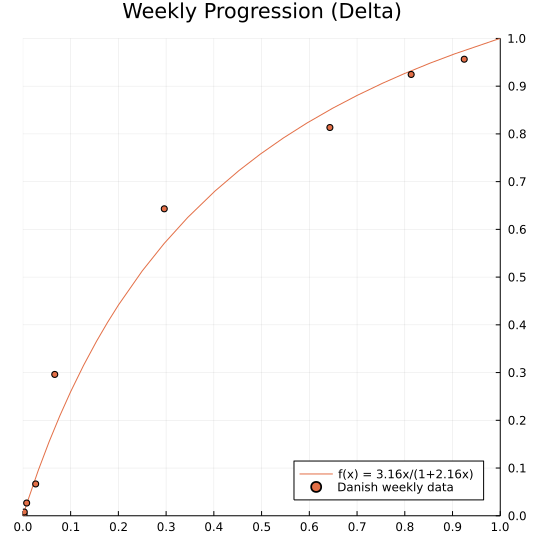

In [51]:
g = 3.16
plot(x->g*x/(1+(g-1)*x),
    xlim=(0,1), xticks = 0.0:0.1:1.0,
    ylim=(0,1), yticks = 0.0:0.1:1.0,
    legend=:bottomright, label="f(x) = $(g)x/(1+$(round(g-1,digits=2))x)", 
    fmt   = png, size=(550,550), seriescolor = 2,
    title = "Weekly Progression (Delta)",
    ymirror=true)
#g = 2
#plot!(x->g*x/(1+(g-1)*x),xlim=(0,1),ylim=(0,1),legend=:bottomright, 
#    label="f(x) = $(g)x/(1+$(round(g-1,digits=2))x)", 
#    seriescolor = 2, 
#    linestyle = :dot
#)
#g = 5
#plot!(x->g*x/(1+(g-1)*x),xlim=(0,1),ylim=(0,1),legend=:bottomright, 
#    label="f(x) = $(g)x/(1+$(round(g-1,digits=2))x)",
#    seriescolor = 2, 
#    linestyle = :dash 
#)
scatter!(dfDelta.q[1:end-1],dfDelta.q[2:end],aspect_ratio = 1,
    label = "Danish weekly data",
    seriescolor = 2
)

## Maximum Likelihood Estimation with Logistic Regression
A better approach to estimating $\gamma$ that makes far better use of the information in the data is maximum likelihood estimation. Assuming that the sequenced positive tests constitute a representative random sample, we know that $x_t$ is binomally distributed $\mathrm{bin}(n_t,\lambda_t)$. 

Likelihood function for observations in week $t$, 
$$ L(\lambda_t) = \binom{N_t}{X_t} \lambda_t^{X_t}(1-\lambda_t)^{N_t-X_t}.$$
The log-likelihood function for all weekly observation is therefore proportional to:
$$ \ell(\lambda_0,\gamma) \propto \sum_{t=1}^T {X_t} \log\lambda_t +({N_t-X_t})\log(1-\lambda_t),$$ where
$\lambda_t=\gamma\lambda_{t-1}/[\gamma\lambda_{t-1}+(1-\lambda_{t-1}]$. The two unknown parameters (to be estimated from data) is the initial value, $\lambda_0$, and our parameter of interest, $\gamma$.

The maximum likelihood estimates of these parameters are simply given by $$(\hat\lambda_0,\hat\gamma) =\arg \max_{\lambda_0,\gamma}\ell(\lambda_0,\gamma),$$
and maximum likelihood gives us ways to test hypothesis and construct confidence intervals for the unknown parameters.

In [52]:
function logL(θ,n,x,output)  
    α = θ[1]
    β = θ[2]
    λ = [1/(1+exp(- α - t*β)) for t in 1:size(n,1)]
    ℓ = x.*log.(λ) .+ (n.-x) .* log.(1.0 .-λ)
    if output=="Total"       # Evaluate log-Likelihood (for maximization)
        sum(ℓ)
    elseif output=="Vector"  # Use for computing scores (Jacobian)
        ℓ
    end
end   
θ = [-10,0.6]
using   Optim, ForwardDiff
obj = θ -> -logL(θ,dfDelta.n,dfDelta.x,"Total")
    res = optimize(obj, θ, autodiff=:forward,iterations =10000,show_trace=false)
    θ .= Optim.minimizer(res)
    ρ̂₀ = exp(θ[1])
    γ̂  = exp(θ[2])
print("The maximum likelihood estimates are ρ̂₀ = $(round(ρ̂₀,digits=4)) and γ̂  = $(round(γ̂,digits=3)).")

The maximum likelihood estimates are ρ̂₀ = 0.0004 and γ̂  = 3.164.

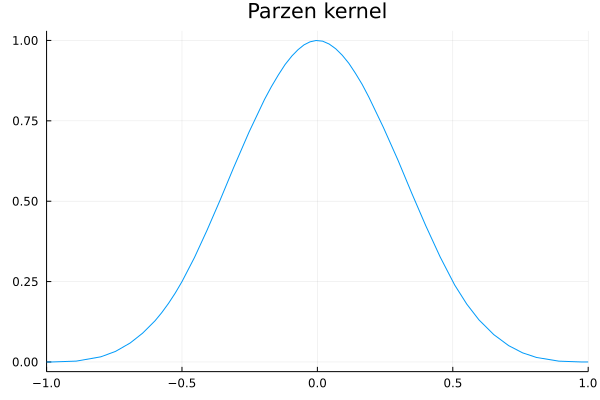

In [53]:
function Parzen(k,K)      # Parzen kernel weights
    x = abs(k/K)
    x==0 ? 1 : x>1 ? 0 : x<0.5 ? 1-6*x^2+6*x^3 : 2*(1-x)^3
end
function VCOV(θ,n,x,K=0)    # computes HAC robust variance covariance matrix
    T     = size(n,1) 
    S  = zeros(T,2)
    λ = [1/(1+exp(-θ[1] - t*θ[2])) for t in 1:T]
    S[:,1] = n.*λ .- x
    S[:,2] = S[:,1] .* [t for t in 1:T]
    h = n.*λ.*(1.0 .- λ)
    A = zeros(2,2)
    for t in 1:T
        A += h[t]*[1, t]*[1 t]
    end
    B = S'S
    for j=1:K
        B +=  Parzen(j,K+1)*(S[j+1:end,:]'S[1:end-j,:]+S[1:end-j,:]'S[j+1:end,:])
    end
    A^(-1)*B*A^(-1)
end  
plot(x->Parzen(convert(Int64,round(x*1000,digits=0)),1000),xlims=(-1,1),title="Parzen kernel",legend=:none)

In [54]:
V̂  = VCOV(θ,dfDelta.n,dfDelta.x,4) 
σ₁ = √V̂[1,1]
σ₂ = √V̂[2,2]

print( "ROBUST STANDARD ERRORS: \n ",
    "α          = ", round(θ[1], digits=2)," [CI 95%: ", 
    round.(θ[1] -1.96*σ₁ , digits=2),",",
    round.(θ[1] +1.96*σ₁ , digits=2),"]       \n ",
    "β = log(γ) = ", round(θ[2], digits=3)," [CI 95%: ", 
    round.(θ[2] -1.96*σ₂ , digits=3),",",
    round.(θ[2] +1.96*σ₂ , digits=3),"]       \n ",
    
    "γ̂week      = ", round(exp(θ[2]), digits=2)," [CI 95%: ", 
    round.(exp.(θ[2] -1.96*σ₂) , digits=2),",",
    round.(exp.(θ[2] +1.96*σ₂) , digits=2),"]       \n ",
    
    "γ̂gen       = ", round(exp(4.7/7*θ[2]), digits=2)," [CI 95%: ", 
    round.(exp.(4.7/7*(θ[2] -1.96*σ₂)) , digits=2),",",
    round.(exp.(4.7/7*(θ[2] +1.96*σ₂)) , digits=2),"]       ")

ROBUST STANDARD ERRORS: 
 α          = -7.81 [CI 95%: -8.75,-6.87]       
 β = log(γ) = 1.152 [CI 95%: 1.026,1.278]       
 γ̂week      = 3.16 [CI 95%: 2.79,3.59]       
 γ̂gen       = 2.17 [CI 95%: 1.99,2.36]       

In [55]:
Del_σ₂ = σ₂
print("For later use: Del_σ₂ = $Del_σ₂ ")

For later use: Del_σ₂ = 0.06449178051672068 

In [56]:
# AVAR GLM (non-robust)
    dfDelta.time_trend = convert(Array{Float64},collect(1:size(dfDelta,1)))
    glmDelta = fit(GeneralizedLinearModel, @formula(x / n ~ time_trend), dfDelta, wts = dfDelta.n, Binomial())
V̂ₙ = vcov(glmDelta)
σ₂ = √V̂ₙ[2,2]

print( "ROBUST STANDARD ERRORS: \n ",
    "γ̂gen       = ", round(exp(4.7/7*θ[2]), digits=2)," [CI 95%: ", 
    round.(exp.(4.7/7*(θ[2] -1.96*σ₂)) , digits=4),",",
    round.(exp.(4.7/7*(θ[2] +1.96*σ₂)) , digits=4),"]   \n ")
for k = 0:6
    V̂  = VCOV(θ,dfDelta.n,dfDelta.x,k) 
    σ₂ = √V̂[2,2]
    print( "ROBUST STANDARD ERRORS K = $k: \n ",
    "γ̂gen       = ", round(exp(4.7/7*θ[2]), digits=2)," [CI 95%: ", 
    round.(exp.(4.7/7*(θ[2] -1.96*σ₂)) , digits=4),",",
    round.(exp.(4.7/7*(θ[2] +1.96*σ₂)) , digits=4),"]       \n ")
end

ROBUST STANDARD ERRORS: 
 γ̂gen       = 2.17 [CI 95%: 2.1319,2.2033]   
 ROBUST STANDARD ERRORS K = 0: 
 γ̂gen       = 2.17 [CI 95%: 2.0215,2.3236]       
 ROBUST STANDARD ERRORS K = 1: 
 γ̂gen       = 2.17 [CI 95%: 2.0119,2.3347]       
 ROBUST STANDARD ERRORS K = 2: 
 γ̂gen       = 2.17 [CI 95%: 2.0009,2.3476]       
 ROBUST STANDARD ERRORS K = 3: 
 γ̂gen       = 2.17 [CI 95%: 1.9949,2.3546]       
 ROBUST STANDARD ERRORS K = 4: 
 γ̂gen       = 2.17 [CI 95%: 1.9909,2.3593]       
 ROBUST STANDARD ERRORS K = 5: 
 γ̂gen       = 2.17 [CI 95%: 1.9888,2.3618]       
 ROBUST STANDARD ERRORS K = 6: 
 γ̂gen       = 2.17 [CI 95%: 1.9888,2.3618]       
 

## Compute Standard Errors Numerically

In [57]:
function Scores(θ,n,x)
    f = θ -> -logL(θ,n,x,"Vector")
    S = ForwardDiff.jacobian(f, θ)
end
function Hessian(θ,n,x)
    f = θ -> -logL(θ,n,x,"Total")
    H = ForwardDiff.hessian(f, θ)
end
S = Scores(θ,dfDelta.n,dfDelta.x)
J = S'S
I  = Hessian(θ,dfDelta.n,dfDelta.x)
inv(I)*J*inv(I)

2×2 Matrix{Float64}:
  0.155008   -0.0200759
 -0.0200759   0.00279876

In [61]:
VCOV(θ,dfDelta.n,dfDelta.x,0) 

2×2 Matrix{Float64}:
  0.155008   -0.0200759
 -0.0200759   0.00279876

## Delta Relative to Ancestral
Here we copy some results from the analysis of the Alpha variant.

In [66]:
β̂ = θ[2]
print("Point estimate is $(round(exp(0.6186184471578016+β̂),digits=3)) \n ")
Lcomb = 0.6186184471578016+β̂-1.96*√(0.008962861521114491^2+Del_σ₂^2)
Ucomb = 0.6186184471578016+β̂+1.96*√(0.008962861521114491^2+Del_σ₂^2)
print( "Per week.     γ̂ combined =", round(exp(0.6186184471578016+β̂),digits=2)," and CI 95%: ", 
    round.(exp.( [Lcomb,Ucomb])',digits=2),"\n ")
print( "Per generation (4.7days).   γ̂(gen) = ", round(exp(4.7/7*(0.6186185185914937+β̂)),digits=2)," and [CI 95%: ", 
    round.(exp.( [4.7/7*Lcomb,4.7/7*Ucomb])',digits=2))

Point estimate is 5.874 
 Per week.     γ̂ combined =5.87 and CI 95%: [5.17 6.67]
 Per generation (4.7days).   γ̂(gen) = 3.28 and [CI 95%: [3.01 3.58]

## Proportion of Delta Variant Implied by Estimated Model

In [67]:
dfDelta.lam = 1.0 ./ (1.0 .+ exp.(-log(ρ̂₀) .- (dfDelta.time_trend).*log(γ̂)))

10-element Vector{Float64}:
 0.0012829145789127866
 0.004048527202543721
 0.012700228728674908
 0.03911449875628581
 0.11411601608601846
 0.28958946914802736
 0.5633115761815001
 0.8032298487697275
 0.9281489014077443
 0.9761210184721838

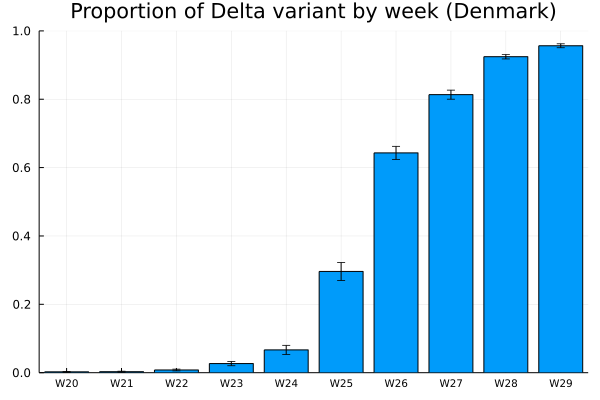

In [68]:
bar( dfDelta.q, legend = :none,  xticks = (1:T, dfDelta.Week), xtickfontsize=7, ylims=(0,1), xlims=(0.5,T+0.5),
    fmt = :png,
      title="Proportion of Delta variant by week (Denmark)",yerror=1.96.*dfDelta.σ)     

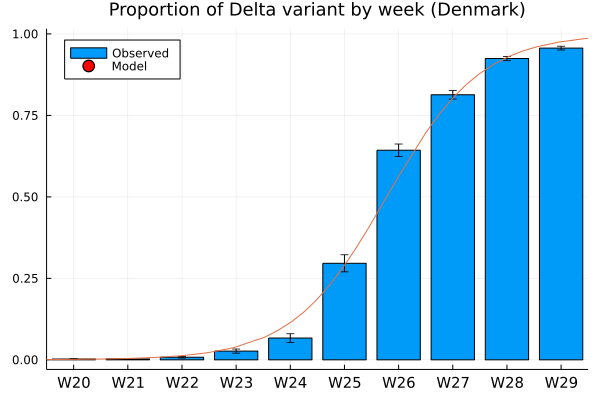

In [69]:
plot1 = bar( dfDelta.q, legend = :topleft, label= "Observed", xticks = (1:1:T, dfDelta.Week[1:1:T]), xtickfontsize=10,
    titlefontsize = 12,
      title="Proportion of Delta variant by week (Denmark)",yerror=1.96.*dfDelta.σ)     
plot!(t -> 1/(1+exp(-log(ρ̂₀) - (t)*log(γ̂))),label = :none, xlims = (0.5,T+0.5),) 
scatter!(dfDelta.time_trend.-19, dfDelta.lam ,label = "Model", xlims = (0.5,T+0.5), color=:red)
plot1 

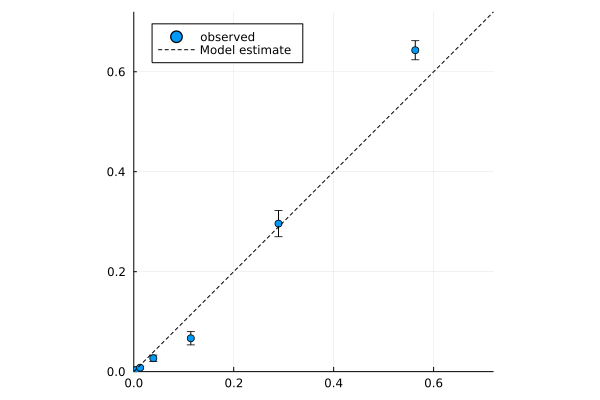

In [71]:
scatter(dfDelta.lam,dfDelta.q,label="observed",legend=:topleft, xlims=(0,0.72),ylims=(0,0.72),
    aspect_ratio = 1,
 yerror=1.96.*dfDelta.σ)
plot!(x->x,label="Model estimate",linestyle=:dash,linecolor=:black)

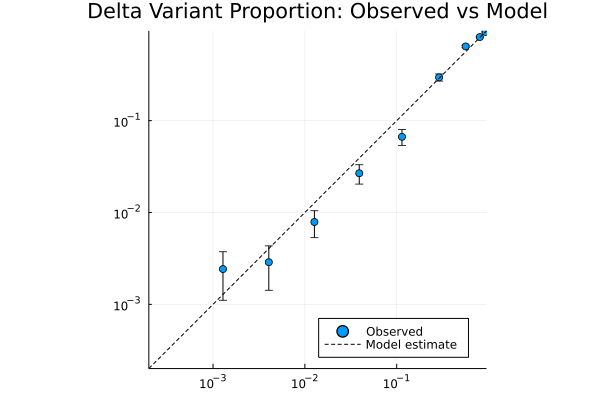

In [72]:
scatter(dfDelta.lam,dfDelta.q,label="Observed",legend=:bottomright, xlims=(0.0002,0.95),ylims=(0.0002,0.95),scale=:log10,
    aspect_ratio = 1, title = "Delta Variant Proportion: Observed vs Model", 
 yerror=1.96.*dfDelta.σ)
plot!([0.0002:0.15:100],[0.0002:0.15:100],label="Model estimate",linestyle=:dash,linecolor=:black)

## Progression of the Odds Ratio

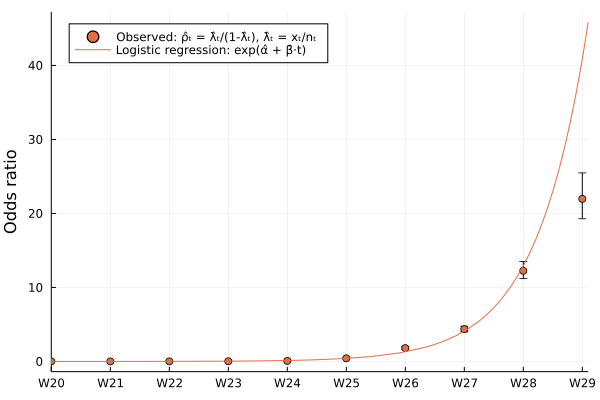

In [73]:
ql = q .- 1.96.*dfDelta.σ
qu = q .+ 1.96.*dfDelta.σ
ρ  = q  ./ (1 .- q)
ρl = ql ./ (1 .- ql) 
ρu = qu ./ (1 .- qu) 

T = size(dfDelta,1)
scatter(dfDelta.time_trend,ρ,  label = "Observed: ρ̂ₜ = λ̂ₜ/(1-λ̂ₜ), λ̂ₜ = xₜ/nₜ",legend = :topleft,  
    ylabel="Odds ratio",
     seriescolor=2,
     xticks = (dfDelta.time_trend, dfDelta.Week),yerror=(ρ-ρl,ρu-ρ) )
plot!(t->exp(α̂+β̂*t),  xlims=(dfDelta.time_trend[1],dfDelta.time_trend[end]+0.1), label = "Logistic regression: exp(α̂ + β̂⋅t)")

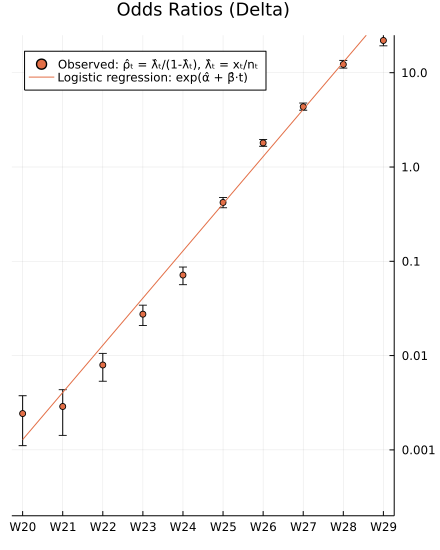

In [80]:
plot2 = 
    scatter(dfDelta.time_trend,ρ, yaxis =:log, label = "Observed: ρ̂ₜ = λ̂ₜ/(1-λ̂ₜ), λ̂ₜ = xₜ/nₜ",legend = :topleft,
        title = "Odds Ratios (Delta)",
        titlefontsize = 12, 
        yticks = ([0.001,0.01,0.1,1,10]),
        xticks = (dfDelta.time_trend, dfDelta.Week),
        yformatter = y -> Float64(y), fmt=png,
        ylims=(0.0002,25), size=(440,550), seriescolor=2,  ymirror = true,
        yerror=(ρ-ρl,ρu-ρ)
    )
plot!(t->exp(α̂+β̂*t),  label = "Logistic regression: exp(α̂ + β̂⋅t)")
plot2 

Output for table

In [81]:
dfTable = select(dfDelta, [:Week, :Cases, :n, :x])
q  = dfDelta.x ./ dfDelta.n
s  = copy(dfDelta.Week)
sr = copy(dfDelta.Week)
using Printf
for i in 1:size(dfTable,1)
   s[i]  = @sprintf("%5.2f%%",100*q[i])
   sr[i] = @sprintf("%5.1f%%",100*dfDelta.SeqRatio[i])
end
dfTable.SeqPct  = sr
dfTable.DeltaFrac = s
latexify(dfTable; env=:table, latex=false)
#dfDelta.Cases

L"\begin{tabular}{cccccc}
Week & Cases & n & x & SeqPct & DeltaFrac\\
W20 & 6867 & 5366 & 13 &  78.1% &  0.24%\\
W21 & 6698 & 5213 & 15 &  77.8% &  0.29%\\
W22 & 5662 & 4565 & 36 &  80.6% &  0.79%\\
W23 & 2811 & 2467 & 66 &  87.8% &  2.68%\\
W24 & 1649 & 1364 & 91 &  82.7% &  6.67%\\
W25 & 1315 & 1165 & 345 &  88.6% & 29.61%\\
W26 & 2674 & 2418 & 1555 &  90.4% & 64.31%\\
W27 & 4614 & 3322 & 2702 &  72.0% & 81.34%\\
W28 & 6818 & 6253 & 5781 &  91.7% & 92.45%\\
W29 & 5289 & 4800 & 4591 &  90.8% & 95.65%\\
\end{tabular}
"

In [82]:
for i in 1:size(dfTable,1)
   print(dfTable.n[i],"  (",dfTable.SeqPct[i],")\n")
end

5366  ( 78.1%)
5213  ( 77.8%)
4565  ( 80.6%)
2467  ( 87.8%)
1364  ( 82.7%)
1165  ( 88.6%)
2418  ( 90.4%)
3322  ( 72.0%)
6253  ( 91.7%)
4800  ( 90.8%)
